In [2]:
import numpy as np
from numpy import zeros, diag, eye, log, pi, sqrt, vstack, exp, mean, load
from numpy.linalg import solve
from scipy.stats import multivariate_normal as MVN
from tangential_hug_functions import Hug, HugTangential, GradientHug, Hop, run_hug_hop, run_thug_hop
from utils import ESS, quick_MVN_scatter, prep_contour, quick_MVN_marginals
import matplotlib.pyplot as plt
from scipy.stats import norm as ndist
from numpy.random import uniform, normal
from scipy.special import gammaincc
from scipy.special import gamma, erf
import tensorflow_probability as tfp
from scipy.optimize import root
from utils import ESS_univariate, box_plot
from IPython.display import display, Latex

In [2]:
# Target distribution is a diagonal MVN
Sigma0 = diag([1.0, 5.0])
rho = 1.0
Sigma = rho * Sigma0
target = MVN(zeros(2), Sigma)

# Initial point on z0-contour
x0 = normal(size=2)
z0 = target.logpdf(x0)      

# Proposal for velocity in HUG/THUG
q = MVN(zeros(2), eye(2))

In [152]:
# Settings
epsilon = 0.0001
T = 20
B = 5
N = 50000
alpha = 0.99

In [153]:
def log_normal_kernel(xi):
    """Log density of normal kernel. """
    return MVN(z0, epsilon**2).logpdf(target.logpdf(xi))
    
def logprior_normal(xi):
    """Log density for normal prior p(xi) of parameters and latents N(0, I)."""
    return MVN(zeros(2), eye(2)).logpdf(xi)
    
def log_abc_posterior(xi):
    """Log density of ABC posterior. Product of (param-latent) prior and uniform kernel."""
    return logprior_normal(xi) + log_normal_kernel(xi)
    
def grad_log_simulator(xi):
    """Gradient of log simulator N(mu, Sigma)."""
    return - solve(Sigma, xi)

In [154]:
hug, ahug  = Hug(x0, T, B, N, q, log_abc_posterior, grad_log_simulator)

In [155]:
thug, athug = HugTangential(x0, T, B, N, alpha, q, log_abc_posterior, grad_log_simulator)

In [156]:
xlims = min(np.min(hug[:, 0]), np.min(thug[:, 0]))*1.2, max(np.max(hug[:, 0]), np.max(thug[:, 0]))*1.2
ylims = min(np.min(hug[:, 1]), np.min(thug[:, 1]))*1.2, max(np.max(hug[:, 1]), np.max(thug[:, 1]))*1.2

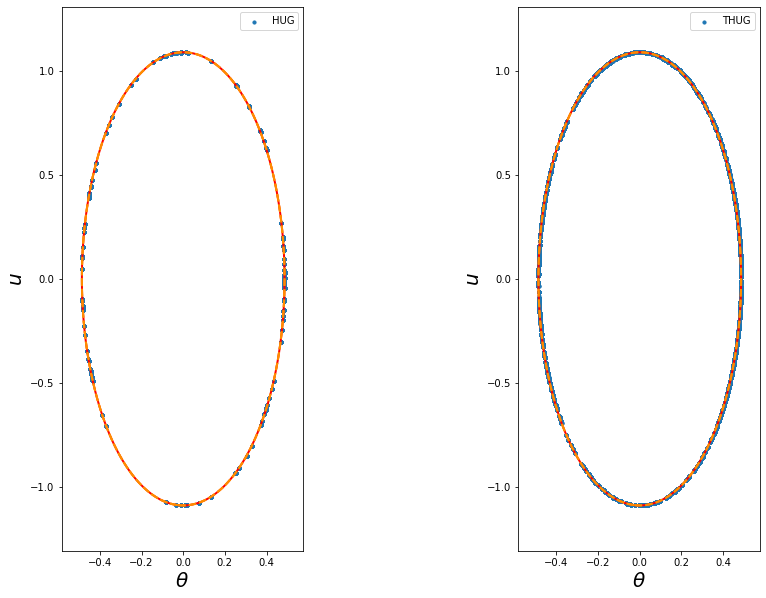

In [157]:
fig, ax = plt.subplots(ncols=2, figsize=(15, 10))
ax[0].contour(*prep_contour(xlims, ylims, 0.01, target.pdf), levels=[exp(z0)], linewidths=2, colors='red')
ax[0].contour(*prep_contour(xlims, ylims, 0.01, target.pdf), levels=[exp(z0-epsilon), exp(z0+epsilon)], linewidths=2, colors='darkorange', linestyles='--')
ax[0].scatter(*hug.T, s=10, label='HUG')
ax[0].legend()
ax[0].set_aspect("equal")
ax[0].set_xlabel("$\\theta$", fontsize=20)
ax[0].set_ylabel("$u$", fontsize=20)
ax[1].contour(*prep_contour(xlims, ylims, 0.01, target.pdf), levels=[exp(z0)], linewidths=2, colors='red')
ax[1].contour(*prep_contour(xlims, ylims, 0.01, target.pdf), levels=[exp(z0-epsilon), exp(z0+epsilon)], linewidths=2, colors='darkorange', linestyles='--')
ax[1].scatter(*thug.T, s=10, label='THUG')
ax[1].legend()
ax[1].set_aspect("equal")
ax[1].set_xlabel("$\\theta$", fontsize=20)
ax[1].set_ylabel("$u$", fontsize=20)
plt.show()

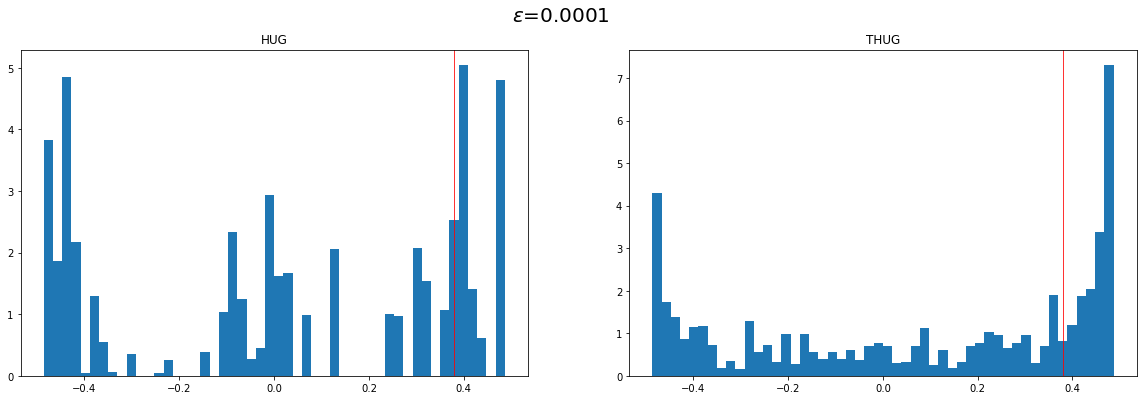

In [158]:
top = np.max(hug[:, 0])*0.99
vals = np.linspace(-top, top) 
fig, ax = plt.subplots(ncols=2, figsize=(20, 6))

_ = ax[0].hist(hug[:, 0], bins=50, density=True)
ax[0].set_title("HUG")
ax[0].axvline(x0[0], color='red', linewidth=0.8)

_ = ax[1].hist(thug[:, 0], bins=50, density=True)
ax[1].set_title("THUG")
ax[1].axvline(x0[0], color='red', linewidth=0.8)
fig.suptitle("$\\epsilon$={}".format(epsilon), fontsize=20)
plt.show()

In [159]:
display(Latex('ESS for $\\theta$ chain'))
print("-"*25)
print("HUG:       {:.6}".format(ESS_univariate(hug[:, 0])))
print("THUG:      {:.6}".format(ESS_univariate(thug[:, 0])))
print("\n")
display(Latex('ESS for $\log p_{\epsilon}(\\xi\mid y^*)$ chain'))
print("-"*25)
print("HUG:      {:.6}".format(ESS_univariate(log_abc_posterior(hug))))
print("THUG:     {:.6}".format(ESS_univariate(log_abc_posterior(thug))))
print("\n")
display(Latex('Acceptance Probabilities'))
print("HUG:      {:.2%}".format(mean(ahug)))
print("THUG:     {:.2%}".format(mean(athug)))
print("\n")
display(Latex('RMSE'))
print("HUG:      {:.4}".format(sqrt(mean((target.logpdf(hug) - z0)**2))))
print("THUG:     {:.4}".format(sqrt(mean((target.logpdf(thug) - z0)**2))))

<IPython.core.display.Latex object>

-------------------------
HUG:       22.0478
THUG:      71.7851




<IPython.core.display.Latex object>

-------------------------
HUG:      38.2316
THUG:     178.902




<IPython.core.display.Latex object>

HUG:      0.26%
THUG:     1.75%




<IPython.core.display.Latex object>

HUG:      0.0001004
THUG:     0.0001029


In [3]:
ESS_HUG       = load("experiment12/ESS_HUG.npy")
ESS_LOGPI_HUG = load("experiment12/ESS_LOGPI_HUG.npy")
A_HUG         = load("experiment12/A_HUG.npy")
RMSE_HUG      = load("experiment12/RMSE_HUG.npy")

ESS_THUG       = load("experiment12/ESS_THUG.npy")
ESS_LOGPI_THUG = load("experiment12/ESS_LOGPI_THUG.npy")
A_THUG         = load("experiment12/A_THUG.npy")
RMSE_THUG      = load("experiment12/RMSE_THUG.npy")

EPSILONS       = load("experiment12/EPSILONS.npy")
ALPHAS         = load("experiment12/ALPHAS.npy")

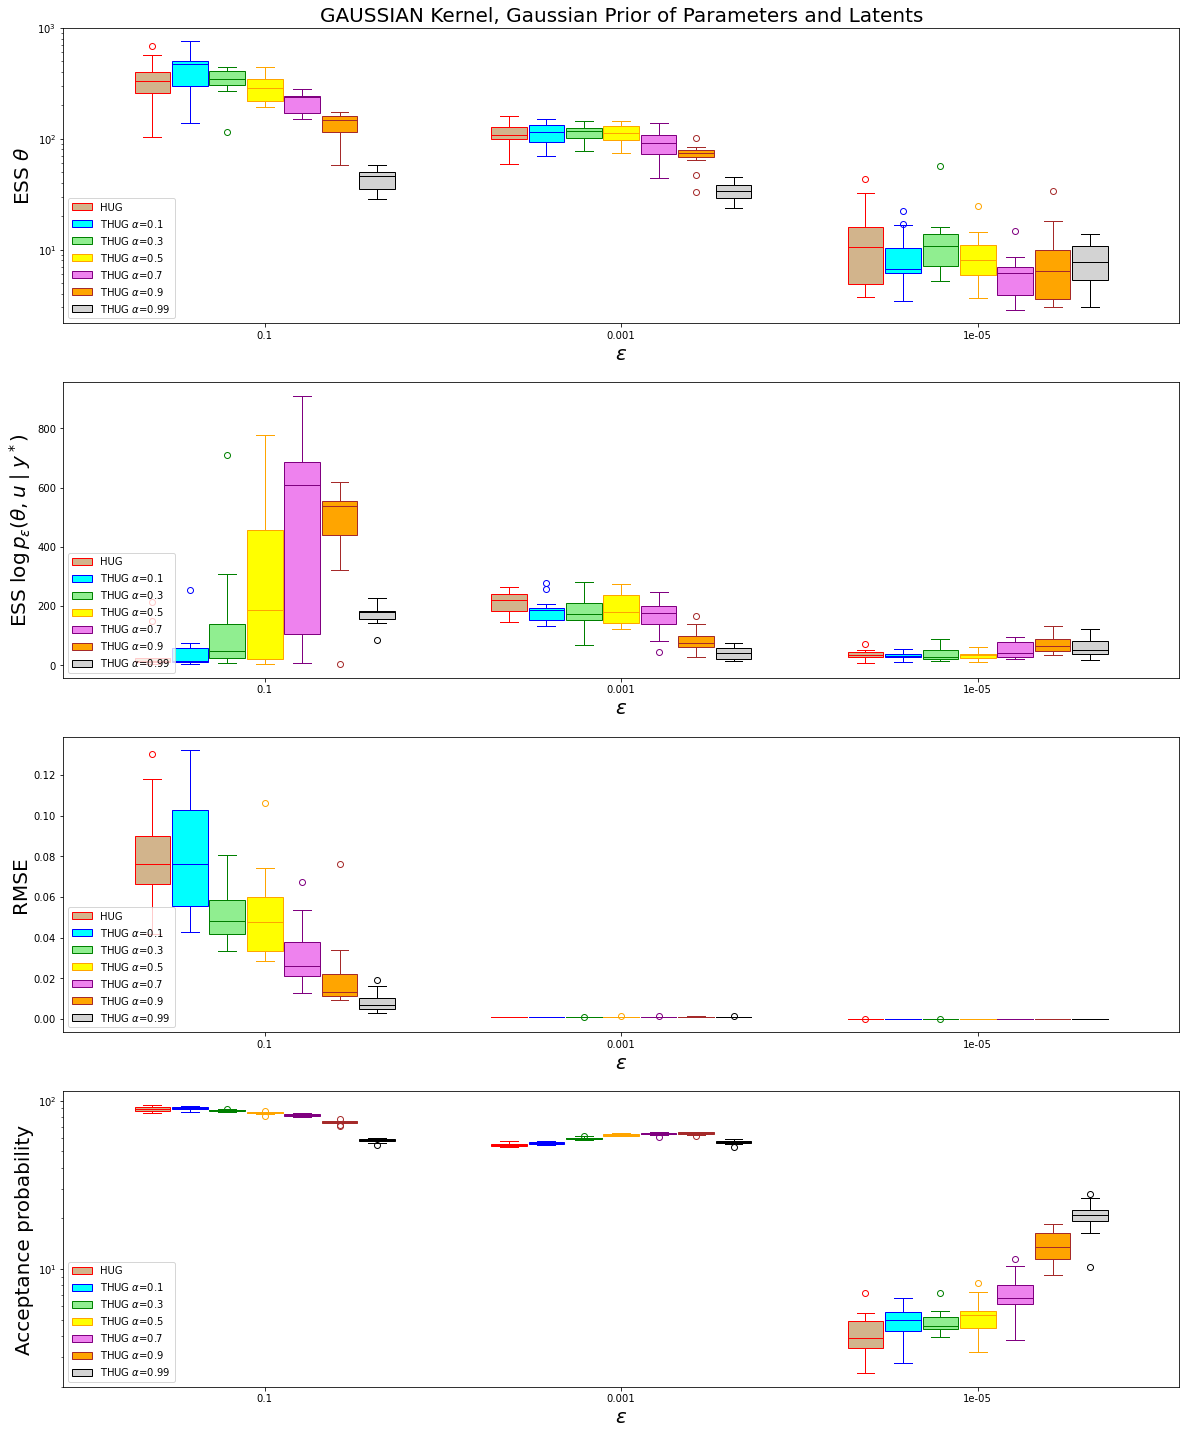

In [4]:
columns = EPSILONS
width = 0.21
n_alphas = len(ALPHAS)
ticks = np.arange(start=1, stop=len(EPSILONS)*2, step=2)
n_boxes = n_alphas + 1
disp = np.linspace(-width * (n_boxes-1) / 2, width * (n_boxes-1) / 2, n_boxes, endpoint=True)
positions = disp.reshape(-1, 1) + ticks
colors1 = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'black']
colors2 = ['tan', 'cyan', 'lightgreen', 'yellow', 'violet', 'orange', 'lightgray']

fig, ax = plt.subplots(nrows=4, figsize=(20, 25))
# Univariate ESS for \theta chain
bp1 = box_plot(ax[0], ESS_HUG.T.tolist(), 'red', 'tan', positions[0])
bps = []
for i in range(len(ALPHAS)):
    bps.append(box_plot(ax[0], ESS_THUG[:,:,i].T.tolist(), colors1[i+1], colors2[i+1], positions[i+1]))
handles = [bp1["boxes"][0]] + [bp["boxes"][0] for bp in bps]
labels = ['HUG'] + ['THUG $\\alpha$={}'.format(alpha) for alpha in ALPHAS]
ax[0].legend(
    handles, 
    labels, 
    loc='lower left')
ax[0].set_xticks(ticks)
ax[0].set_xticklabels(columns)
ax[0].set_xlabel("$\\epsilon$", fontsize=20)
ax[0].set_ylabel("ESS $\\theta$", fontsize=20)
ax[0].semilogy()

# ESS for joint ABC posterior
bp1_joint = box_plot(ax[1], ESS_LOGPI_HUG.T.tolist(), 'red', 'tan', positions[0])
bps_joint = []
for i in range(len(ALPHAS)):
    bps_joint.append(box_plot(ax[1], ESS_LOGPI_THUG[:,:,i].T.tolist(), colors1[i+1], colors2[i+1], positions[i+1]))
handles = [bp1_joint["boxes"][0]] + [bp["boxes"][0] for bp in bps_joint]
labels = ['HUG'] + ['THUG $\\alpha$={}'.format(alpha) for alpha in ALPHAS]
ax[1].legend(
    handles, 
    labels, 
    loc='lower left')
ax[1].set_xticks(ticks)
ax[1].set_xticklabels(columns)
ax[1].set_xlabel("$\\epsilon$", fontsize=20)
ax[1].set_ylabel("ESS $\log p_{\\epsilon}(\\theta, u \mid y^*)$", fontsize=20)
# ax[1].semilogy()

# RMSE 
bp1_rmse = box_plot(ax[2], RMSE_HUG.T.tolist(), 'red', 'tan', positions[0])
bps_rmse = []
for i in range(len(ALPHAS)):
    bps_rmse.append(box_plot(ax[2], RMSE_THUG[:,:,i].T.tolist(), colors1[i+1], colors2[i+1], positions[i+1]))
handles = [bp1_rmse["boxes"][0]] + [bp["boxes"][0] for bp in bps_rmse]
labels = ['HUG'] + ['THUG $\\alpha$={}'.format(alpha) for alpha in ALPHAS]
ax[2].legend(
    handles, 
    labels, 
    loc='lower left')
ax[2].set_xticks(ticks)
ax[2].set_xticklabels(columns)
ax[2].set_xlabel("$\\epsilon$", fontsize=20)
ax[2].set_ylabel("RMSE", fontsize=20)
# ax[2].semilogy()

# ACCEPTANCE PROBABILITY 
bp1_a = box_plot(ax[3], A_HUG.T.tolist(), 'red', 'tan', positions[0])
bps_a = []
for i in range(len(ALPHAS)):
    bps_a.append(box_plot(ax[3], A_THUG[:,:,i].T.tolist(), colors1[i+1], colors2[i+1], positions[i+1]))
handles = [bp1_a["boxes"][0]] + [bp["boxes"][0] for bp in bps_a]
labels = ['HUG'] + ['THUG $\\alpha$={}'.format(alpha) for alpha in ALPHAS]
ax[3].legend(
    handles, 
    labels, 
    loc='lower left')
ax[3].set_xticks(ticks)
ax[3].set_xticklabels(columns)
ax[3].set_xlabel("$\\epsilon$", fontsize=20)
ax[3].set_ylabel("Acceptance probability", fontsize=20)
ax[3].semilogy()

ax[0].set_title("GAUSSIAN Kernel, Gaussian Prior of Parameters and Latents", fontsize=20)
plt.show()